In [98]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import pulp
from gurobipy import Model, GRB, quicksum, abs_
from sklearn.datasets import make_blobs
from ucimlrepo import fetch_ucirepo

In [100]:
############################################# set up parameters ###################################################
beta = 1.5
k = 4
epsilon = 0.25

alpha = 11
delta = 2
gamma = float(10 / 9)
eta = 1 / np.log((alpha - gamma * (1 + delta))/ (2 * gamma))

In [102]:
################################################ useful methods ###################################################
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calculate_diameter(points):
    diameter = 0.0
    num_points = len(points)
    for i in range(num_points):
        for j in range(i+1, num_points):
            distance = euclidean_distance(points[i], points[j])
            if distance > diameter:
                diameter = distance
    return diameter

def plot_multiple_lines(x, y_list, labels, colors, title='Multiple Line Graph', x_label='X Axis', y_label='Y Axis'):
    plt.figure(figsize=(10, 5))  # Set the figure size
    for y, label, color in zip(y_list, labels, colors):
        plt.plot(x, y, label=label, color=color, marker='o')  # Plot each line with a specified label and color
    plt.title(title)  # Set the title of the graph
    plt.xlabel(x_label)  # Set the label for the x-axis
    plt.ylabel(y_label)  # Set the label for the y-axis
    plt.legend()  # Show legend
    plt.grid(True)  # Enable grid
    plt.show()

In [104]:
############################### offline algorithm to produce offline OPT distance #################################

def calculate_total_cost(points, open_facilities, uniform_cost):
    total_cost = 0
    for client_point in points:
        distance = float('inf')
        for facility in open_facilities:
            if euclidean_distance(client_point, points[facility]) < distance:
                distance = euclidean_distance(client_point, points[facility])
        total_cost += distance
    total_cost += uniform_cost * len(open_facilities)

    return total_cost

# LP relaxation for facility location
def lp_relaxation_facility_location(points, candidate_locations, cost, k):

    num_clients = len(points)
    num_facilities = len(candidate_locations)
    
    # calculate distance matrix
    dist_mat = np.zeros((num_clients, num_facilities))
    for i in range(num_facilities):
        for j in range(num_clients):
            dist_mat[i][j] = euclidean_distance(candidate_locations[i], points[j])
    #print("\ndistance matrix:", dist_mat)
    
    problem = pulp.LpProblem("Facility_Location", pulp.LpMinimize)

    # Decision variables
    x = [pulp.LpVariable(f"x_{i}", 0, 1, cat=pulp.LpContinuous) for i in range(num_facilities)]
    y = [[pulp.LpVariable(f"y_{i}_{j}", 0, 1, cat=pulp.LpContinuous) for j in range(num_clients)] for i in range(num_facilities)]

    # Objective function
    problem += pulp.lpSum([cost * x[i] for i in range(num_facilities)]) + \
               pulp.lpSum([dist_mat[i][j] * y[i][j] for i in range(num_facilities) for j in range(num_clients)])

    # Constraints
    for j in range(num_clients):
        problem += pulp.lpSum([y[i][j] for i in range(num_facilities)]) >= 1, f"ServiceConstraint_{j}"

    for i in range(num_facilities):
        for j in range(num_clients):
            problem += y[i][j] <= x[i], f"OpenConstraint_{i}_{j}"

    problem += pulp.lpSum(x[i] for i in range(num_facilities)) <= k

    # Solve the problem
    problem.solve(pulp.PULP_CBC_CMD(msg=False))

     # print out the x matrix for debugging
    total_cost = 0
    y_mat = np.zeros((num_facilities, num_clients))
    for i in range(num_facilities):
        for j in range(num_clients):
            y_mat[i, j] = y[i][j].varValue
            total_cost += y_mat[i][j] * dist_mat[i][j]
    #print("Y matrix:\n", y_mat.T)

    x_vec = np.zeros(num_facilities)
    for i in range(num_facilities):
        x_vec[i] = x[i].varValue
    #print("x vector:\n", x_vec)

    #print(f"Total cost from lp= {pulp.value(problem.objective)}")

    return total_cost

In [106]:
def plot_points_and_centers(points, centers):
    plt.figure(figsize=(8, 6))
    x, y = zip(*points)
    cx, cy = zip(*centers)
    
    plt.scatter(x, y, color='blue', label='Points')
    plt.scatter(cx, cy, color='red', s=100, label='Centers', edgecolors='black')
    plt.title("Dynamic k-Center Clustering")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [108]:
################################# functions needed for main method ####################################

############################ method used to compute OPT_rec at time t #################################

# arguments: 
# Compute the OPT_rec LP and use this solution for rounding 
# T: the number of steps so far

def compute_OPT_rec(t, valid_indices, candidate_locations, distances, cost, OPT_list, beta, epsilon, k):
    #print("\nComputing OPT_recourse...")
    # Problem data and parameters
    T = t + 1  # Number of time periods
    num_facilities = len(candidate_locations)
    num_clients = len(candidate_locations)
    #weights = {t: [1]*n for t in range(0, T)}  # Example weights

    #print("OPT cost:", OPT)
    #print("valid indices:", valid_indices)
    #print("budget beta * (1 + epsilon) * OPT = ", beta * (1 + epsilon) * OPT_list[t])

    m = Model("dynamic_optimization")
    m.setParam('OutputFlag', 0)

    # Create variables
    x = {(i, t): m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"x_{i}_{t}") for t in range(T) for i in range(num_facilities)}
    y = {(i, j, t): m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"y_{i}_{j}_{t}") for t in range(T) for i in valid_indices[t] for j in valid_indices[t]}
    abs_diff = {(i, t): m.addVar(vtype=GRB.CONTINUOUS, name=f"abs_diff_{i}_{t}") for i in range(T) for t in range(T)}

    # Objective function: Minimize the sum of absolute changes in x
    m.setObjective(quicksum(abs_diff[i, t] for i in range(num_facilities) for t in range(T)), GRB.MINIMIZE)

    # Constraints
    for t in range(T):
        for j in valid_indices[t]:
            m.addConstr(quicksum(y[(i, j, t)] for i in valid_indices[t]) >= 1, name=f"Coverage_{j}_{t}")
            for i in valid_indices[t]:
                m.addConstr(y[(i, j, t)] <= x[(i, t)], name=f"Cap_{i}_{j}_{t}")

        # Budget constraints
        m.addConstr(quicksum(cost * x[(i, t)] +  quicksum(distances[i][j] * y[(i, j, t)] for j in valid_indices[t]) for i in valid_indices[t]) <= (1 + epsilon) * beta * OPT_list[t], name=f"Budget_{t}")
        m.addConstr(quicksum(x[(i, t)] for i in valid_indices[t]) <= (1 + epsilon) * k)

    for t in range(1, T):
        for i in range(num_facilities):  # Only for i present in both t and t-1
            m.addConstr(abs_diff[i, t] >= x[i, t] - x[i, t-1])
            m.addConstr(abs_diff[i, t] >= -(x[i, t] - x[i, t-1]))
    for i in range(num_facilities):
        m.addConstr(abs_diff[i, 0] >= x[i, 0])

    # Solve the model
    m.optimize()

    x_mat = np.zeros((T, num_facilities))

    # Output the results
    if m.status == GRB.OPTIMAL:
        #print("Optimal solution found:")
        for t in range(T):
            for i in valid_indices[t]:
                #print(f"x_{i}_{t} = {x[(i, t)].X}")
                x_mat[t][i] = x[(i, t)].X
        #print("X_OPT:\n")
        #print(x_mat)

        y_mat_t = np.zeros((num_clients, num_facilities))
        for t in range(T):
            cost_sum = 0
            #print ("\nfor t = ", t)
            #print("budget beta * (1 + epsilon) * OPT = ", beta * (1 + epsilon) * OPT_list[t])
            for j in valid_indices[t]:
                for i in valid_indices[t]:
                    #print(f"y_{i}_{j}_{t} = {y[(i, j, t)].X}")
                    y_mat_t[j][i] = y[(i, j, t)].X
                    cost_sum += distances[i][j] * y_mat_t[j][i]
            cost_sum += quicksum(cost * x_mat[t, i] for i in range(len(x_mat[0])))
            #print("total cost this round:", cost_sum)
            #print("y matrix: ", t)
            #print(y_mat_t)
        
        objective = 0
        for t in range(1, T):
            objective += quicksum(abs(x_mat[t] - x_mat[t-1]))
        objective += quicksum(x_mat[0])
        #print("objective value:", objective)

    #print("Total OPT_recourse = ", pulp.value(lp_prob.objective))
    #print("Status:", pulp.LpStatus[lp_prob.status])
    return x_mat[-1], y_mat_t, objective 

In [110]:
######################################### helper for rounding ###########################################

# subroutine to find the balls B_i and B_hait_i for a given center_index
# this subroutine is called whenever the set S is updated
def find_ball(client, dist_mat, facility_indices, radius):

    B_j = []
    for facility in facility_indices:
        if dist_mat[facility][client] <= radius[client]:
            B_j.append(facility)

    return B_j

def get_uncovered_client(client_indices, dist_mat, open_facilities, R_j):
    uncovered = []
    for client in client_indices:
        covered = False
        for facility in open_facilities:
            if dist_mat[facility][client] <= alpha * R_j[client]:
                covered = True
        if covered == False:
            uncovered.append(client)
    return uncovered

In [112]:
###################################### main method for online k-center ####################################

def online_facility_location(requests, points, cost, k):

    total_rounding_recourse = 0

    num_clients = len(points)
    num_facilities = len(points)
    
    valid_indices = []
    OPT_list = []

    # initialize the vector x with all 0s of dimension len(points)
    x = np.zeros(num_facilities)
    y = np.zeros((num_facilities, num_clients))

    dist_mat = np.zeros((num_facilities, num_clients))
    for i in range(num_facilities):
        for j in range(num_clients):
            dist_mat[i][j] = euclidean_distance(points[i], points[j])
        
    dist_mat_list = []

    client_indices = []
    client_coordinates = []
    open_facilities = []
    active_clients = []

    B = [[] for _ in range(num_clients)]
    radius = np.zeros(num_clients)
    facility_of_client = np.full(num_clients, -1)
    
    cost_array = np.zeros(len(points))
    OPT_cost_array = np.zeros(len(points))
    
    OPT_rec_arr = []
    #OPT_rec_arr = np.zeros(len(points))
    rounding_rec_arr = np.zeros(len(points))

    num_centers_arr = np.zeros(len(points))

    t = 0  # for indexing the data points     
    for r in range(len(requests)):

        x_old = np.copy(x)

        #print("\n")
        #print("---------request:", r)
        #print("t =", t)
        
        if requests[r] == -1:
            
            # random sample an active client to 
            if len(client_indices) > 0:
                client_to_remove = random.randint(0, t)
                while client_to_remove in open_facilities or client_to_remove not in client_indices:
                    client_to_remove = random.randint(0, t)
                
                x[client_to_remove] = 0
                
                if client_to_remove in client_indices:
                    client_indices.remove(client_to_remove)
            continue
            
        # the request is an insertion, add the new client and deal with any constraint violations
        # set of active clients
        client_indices.append(t)
        client_coordinates.append(points[t])

        indices_t = copy.deepcopy(client_indices)
        valid_indices.append(indices_t)
        #print("valid indices so far:", valid_indices)

        facility_locations = client_coordinates
        client_locations = client_coordinates

        current_num_clients = len(client_locations)
        current_num_facilities = len(facility_locations)

        facility_indices = client_indices
        
        #print("\n")
        #print("t= ", t)
        #print("current client:", client_coordinates[t])

        current_OPT_cost = lp_relaxation_facility_location(client_locations, facility_locations, cost, k)
        #print("current OPT cost:", current_OPT_cost)
        OPT_list.append(current_OPT_cost)
        OPT_cost_array[t] = current_OPT_cost

        #print("diam(t):", diam)
        #print("current_OPT_cost:", current_OPT_cost)

        current_dist_mat = np.zeros((current_num_facilities, current_num_clients))
        for i in range(current_num_facilities):
            for j in range(current_num_clients):
                current_dist_mat[i][j] = dist_mat[i][j]

        #print("current distance matrix:")
        #print(current_dist_mat)
        #dist_mat_list.append(current_dist_mat)
        
        x_OPT, y_OPT, OPT_recourse = compute_OPT_rec(t, valid_indices, facility_locations, current_dist_mat, cost, OPT_list, beta, epsilon, k)
        #OPT_rec_arr[t] = float(OPT_recourse)
        OPT_rec_arr.append(OPT_recourse)

        #print("fractional solution this round:", x_OPT)
        
        #################################### rounding procedure begins from here ####################################
        
        # R_j for each client j is the fractional connection cost sum(distance[i][j] * y[i][j])
        # B_j of each client j is the set of facility locations within radius[j] of j
        # during rounding at each iteration, we first determine these two variables for each j
        # we then drop any ball whose mass is too small (< 1 / alpha)
        # Note: y_OPT where the rows are indexed by clients and columns are indexed by facilities
        
        #print("y_OPT matrix:\n", y_OPT)
        #print("current distances:\n", current_dist_mat)
        #print("\nRounding...")
        #print("current open facilities:", open_facilities)
        S_prev = copy.deepcopy(open_facilities)
        
        R_j = np.zeros(current_num_clients)
        for client in client_indices:
            for i in range(current_num_facilities):
                R_j[client] += y_OPT[client][i] * dist_mat[i][client]
            
            #print("R_j of j = ", client)
            #print(R_j[client])
            B[client] = find_ball(client, dist_mat, facility_indices, radius) 
            #print("radius r_j of j = ", client)
            #print(radius[client])
            #print("B_j contains:", B[client])

            #print("mass of ball:", np.sum(x_OPT[B[client]]))
            if np.sum(x_OPT[B[client]]) < 1 / alpha:
                if client in active_clients and facility_of_client[client] != -1:
                    active_clients.remove(client)
                    #print("active client dropped:", client)
                    open_facilities.remove(facility_of_client[client])
                    #print("associated facility dropped:", facility_of_client[client])
        
        # Iteratively add any client j that is not covered, i.e., a j that is farther than 
        # alpha * R_j away from all open facilities
        uncovered_clients = get_uncovered_client(client_indices, current_dist_mat, open_facilities, R_j)
        #print("uncovered client:", uncovered_clients)
        
        while len(uncovered_clients) > 0:
            for client in uncovered_clients:
                #print("adding new client...", client)
                active_clients.append(client)
                total_rounding_recourse += 1
                radius[client] = gamma * R_j[client]
                #print("with r_j = ", gamma * R_j[client])
                B_j = find_ball(client, dist_mat, facility_indices, radius)
                # pick one to be the associated facility since costs are uniform
                facility = B_j[0]
                #print("and associated facility:", facility)
                facility_of_client[client] = facility
                open_facilities.append(facility)
                
                A_t = copy.deepcopy(active_clients)
                for diff_client in A_t:
                    if diff_client != client and dist_mat[client][diff_client] <= radius[client] + radius[diff_client] + delta * min(radius[client], radius[diff_client]):
                        active_clients.remove(diff_client)
                        open_facilities.remove(facility_of_client[diff_client])
            
            uncovered_clients = get_uncovered_client(client_indices, current_dist_mat, open_facilities, R_j)
        
        #diff = set(S_prev) ^ set(open_facilities)
        #total_rounding_recourse += len(diff)
        
        #print("all clients covered!")
        #print("open facilities this round:", open_facilities)
        
        cost_array[t] = calculate_total_cost(client_locations, open_facilities, cost)
        rounding_rec_arr[t] = total_rounding_recourse

        num_centers_arr[t] = len(open_facilities)
        
        t += 1

    return x_OPT, open_facilities, OPT_recourse, total_rounding_recourse, cost_array, OPT_cost_array, OPT_rec_arr, rounding_rec_arr, num_centers_arr

In [146]:
# fetch datasets from UCI ML repo
num_of_points = 100

data_list = [42, 186, 291]
Y_dist = np.zeros(num_of_points)
T = np.zeros(num_of_points)
for i in range(num_of_points):
    T[i] = i

# fetch dataset
#id_num = data_list[i]
id_num = 291
df = fetch_ucirepo(id=id_num) 
  
# data (as pandas dataframes) 
X = df.data.features 
y = df.data.targets 
  
# variable information 
print(df.variables) 

ucirepo_points = X.to_numpy()
data_points = ucirepo_points

data_points = random.sample(list(data_points), num_of_points)
random.shuffle(data_points)

                                  name     role        type demographic  \
0                            frequency  Feature     Integer        None   
1                         attack-angle  Feature      Binary        None   
2                         chord-length  Feature  Continuous        None   
3                 free-stream-velocity  Feature  Continuous        None   
4  suction-side-displacement-thickness  Feature  Continuous        None   
5                scaled-sound-pressure   Target  Continuous        None   

  description units missing_values  
0        None    Hz             no  
1        None   deg             no  
2        None     m             no  
3        None   m/s             no  
4        None     m             no  
5        None    dB             no  


In [148]:
#####################################################################################################################
################################################### main ############################################################
##################################################################################################################### 

## parse inputs
# Generate random points
#np.random.seed(42)
#all_points = np.random.rand(200, 2) * 100  # 100 points in a 100x100 grid
#data_points = random.sample(list(all_points), 10)
#candidate_locations = data_points
#plot_points(data_points)
#print(data_points)

# Alternative Method 2: generate test points in clusters 
# Settings for the clusters
n_samples = 200          # Total number of points
n_features = 2           # Number of dimensions (2D)
centers = 4              # Number of clusters
cluster_std = 1        # Standard deviation of clusters
cluster_points, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std, random_state=42)

# We'll add 10-20% of the amout of data to be removal requests
# to simulate dynamic streaming.
# For simplicity, whenever we encounter a removal request,
# we randomly sample an active client point that is not in the set of centers
# In our request array. a +1 indicates an insertion of a client;
# -1 indicates a removal.
#data_points = cluster_points

#data_points = random.sample(list(data_points), 150)
#random.shuffle(data_points)

requests = np.ones(int(len(data_points)))
#removals = np.random.choice(range(0, len(data_points)+ 1), int(len(data_points)*0.2), replace=False)
#print(removals)
#requests[removals] = -1
#print(requests)

print("\n")
print("-----------final online results-----------")
print("beta = ", beta)
print("epsilon = ", epsilon)

# (optional) for plotting
#for i in range(len(centers)):
    #center_coordinates[i] = data_points[centers[i]]
#plot_points_and_centers(data_points, center_coordinates)
uniform_cost = 0
#print("uniform cost:", uniform_cost)

offline_OPT_cost = lp_relaxation_facility_location(data_points, data_points, uniform_cost, k)
print("offline OPT cost from lp:", offline_OPT_cost)

fractional_x, open_facilities, OPT_recourse, rounding_recourse, Y_dist, Y_OPT_dist, OPT_rec_arr, rounding_rec_arr, num_centers = online_facility_location(requests, data_points, uniform_cost, k)

print("final open facilities:", open_facilities)
print("OPT recourse:", OPT_recourse)
print("total rounding recourse:", rounding_recourse)
print("final online cost:", calculate_total_cost(data_points, open_facilities, uniform_cost))
print("alpha * beta * offline OPT cost:", alpha * beta * offline_OPT_cost)
print("number of centers:", num_centers)



-----------final online results-----------
beta =  1.5
epsilon =  0.25
offline OPT cost from lp: 63273.08154488599
final open facilities: [0, 1, 2, 3]
OPT recourse: 5.431136114523617
total rounding recourse: 4
final online cost: 96839.63051122084
alpha * beta * offline OPT cost: 1044005.8454906187
number of centers: [1. 2. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]


offline dist: [    0.             0.             0.             0.
   133.90260113   304.94312646  1671.57443253  1704.26005597
  1737.10604151  3437.10604151  3819.23746683  4134.63347188
  4506.25654166  4677.72951484  5107.8099445   5108.03758663
  6478.40780366  6830.79896579  8030.93672487  8035.73840474
  8236.37471988  9105.01989916  9457.13412038  9491.4725958
  9940.85502207 10442.59439755 10942.61203982 11343.86719877
 12193.99289627 12325.96342997 12457.02763839 14121.72766219
 15817.80528054 15988.00722359 16358.04519182 16488.15321589
 16500.04441728 16816.68157759 16829.38181093 18133.32989804
 18308.34273009 18481.36052148 18514.45460049 18648.33283131
 19030.48972493 19033.39089737 19163.39100289 19174.41593648
 19183.66407516 19354.48222786 19354.79441023 21055.09258702
 21073.50621313 21245.23698227 22545.62623293 22564.68591393
 23184.89483147 23834.95023124 25135.08516406 25138.38517124
 25638.43416935 26938.82949696 27369.14874663 28269.42091716
 31969.57851626 322

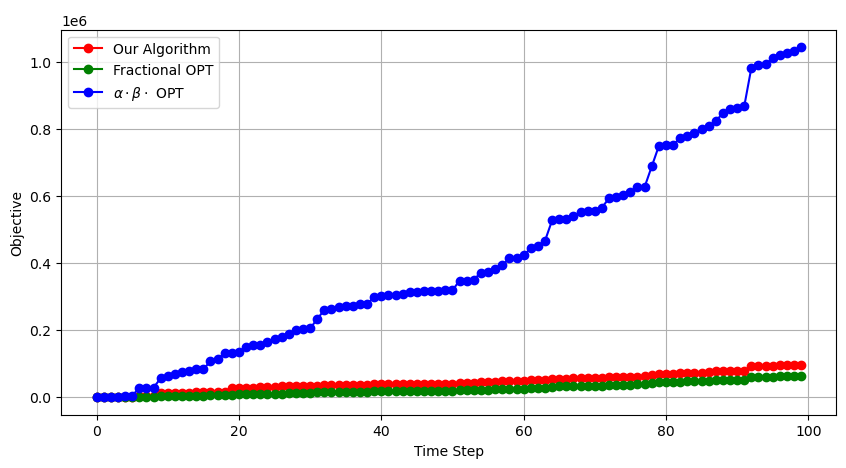

In [150]:
# plot the costs at each t
for i in range(len(Y_dist)):
    if Y_dist[i] == 0 and i >= (1 + epsilon) * k:
        Y_dist[i] = Y_dist[i-1]
    
    if Y_OPT_dist[i] == 0 and i >= k:
        Y_OPT_dist[i] = Y_OPT_dist[i-1]

Y_bound = np.zeros(len(Y_OPT_dist))
Y_bound = beta * alpha * Y_OPT_dist

#print("online dist:", Y_dist)
print("offline dist:", Y_OPT_dist)
#print("beta * alpha dist:", Y_bound)

plot_multiple_lines(T, [Y_dist, Y_OPT_dist, Y_bound], 
                    labels=['Our Algorithm', 'Fractional OPT', r'$\alpha \cdot \beta \cdot$ OPT'],
                    colors=['red', 'green', 'blue'],
                    title=' ',
                    x_label='Time Step', 
                    y_label='Objective')

OPT recourse at each t: [<gurobi.LinExpr: 1.0>, <gurobi.LinExpr: 2.0>, <gurobi.LinExpr: 3.0>, <gurobi.LinExpr: 4.0>, <gurobi.LinExpr: 4.0>, <gurobi.LinExpr: 4.635134618721329>, <gurobi.LinExpr: 4.635134618721329>, <gurobi.LinExpr: 4.635134618721329>, <gurobi.LinExpr: 4.635134618721329>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.LinExpr: 5.431136114523617>, <gurobi.L

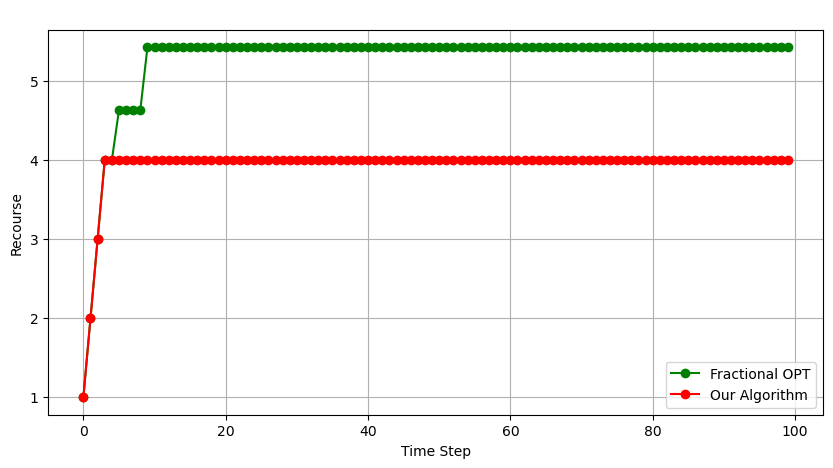

In [152]:
# plot the rounding and OPT recourses at each t
print("OPT recourse at each t:", OPT_rec_arr)
print("rounding recourse at each t:", rounding_rec_arr)

for i in range(len(OPT_rec_arr)):
    OPT_rec_arr[i] = OPT_rec_arr[i].getValue()
    if OPT_rec_arr[i] == 0:
        OPT_rec_arr[i] = OPT_rec_arr[i-1]
    if rounding_rec_arr[i] == 0:
        rounding_rec_arr[i] = rounding_rec_arr[i-1]

print("OPT recourse at each t:", OPT_rec_arr)
print("rounding recourse at each t:", rounding_rec_arr)

plot_multiple_lines(T, [OPT_rec_arr, rounding_rec_arr], 
                    labels=['Fractional OPT', 'Our Algorithm'],
                    colors=['green', 'red'],
                    title=' ',
                    x_label='Time Step', 
                    y_label='Recourse')

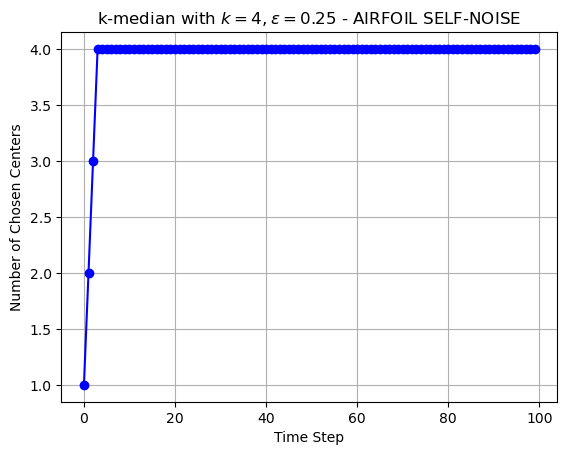

In [154]:
#print("T.shape =", np.array(T).shape)
#print("num_centers.shape =", np.array(num_centers).shape)

# plot the number of chosen centers at each t
plt.plot(T, num_centers, marker='o', color='b') # plot line with circle markers
plt.title("k-median with $k = 4, \epsilon = 0.25$ - AIRFOIL SELF-NOISE") 
plt.xlabel("Time Step")           
plt.ylabel("Number of Chosen Centers")
plt.grid(True)                        # optional: add a grid
plt.show()